## 1. Import libraries and set paths, filenames

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

rc_metdata_path = '../data/rcczo_daily_climatefields/'

bgc_out_fname = './rcczo_rme.met'

x_rcczo_pt = 520468.128677634
y_rcczo_pt = 4768006.21823093

start_date = '2005-01-01'
end_date = '2007-12-31'

## 2. Open RC CZO daily met climate fields

In [2]:
tmax_fname_base = 'ta_max_wy'
tmin_fname_base = 'ta_min_wy'
tmean_fname_base = 'ta_mean_wy'
prcp_fname_base = 'precip_sum_wy'
rh_fname_base = 'rh_mean_wy'
srad_fname_base = 'cloud_solar_mean_wy'

ds_tmax = xr.open_mfdataset(rc_metdata_path+tmax_fname_base+'*.nc',combine='by_coords')
ds_tmin = xr.open_mfdataset(rc_metdata_path+tmin_fname_base+'*.nc',combine='by_coords')
ds_tmean = xr.open_mfdataset(rc_metdata_path+tmean_fname_base+'*.nc',combine='by_coords')
ds_prcp = xr.open_mfdataset(rc_metdata_path+prcp_fname_base+'*.nc',combine='by_coords')
ds_rh = xr.open_mfdataset(rc_metdata_path+rh_fname_base+'*.nc',combine='by_coords')
ds_srad = xr.open_mfdataset(rc_metdata_path+srad_fname_base+'*.nc',combine='by_coords')

## 3. Interpolate to the point in space and period in time of interest

### 3.1 Start with maximum and minimum daily air temperature and plot to verify

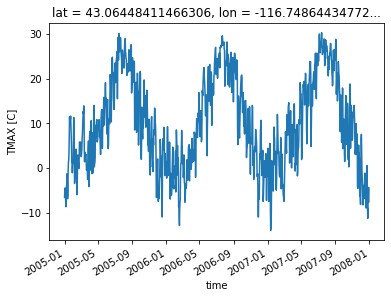

In [3]:
da_tmax_pt = ds_tmax.interp(x=x_rcczo_pt,y=y_rcczo_pt).sel(time=slice(start_date,end_date))
da_tmax_pt.TMAX.plot()

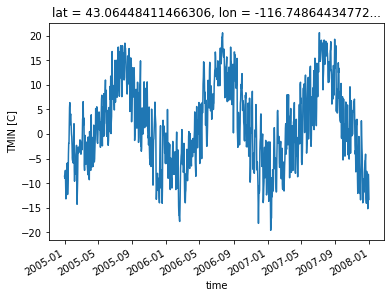

In [4]:
da_tmin_pt = ds_tmin.interp(x=x_rcczo_pt,y=y_rcczo_pt).sel(time=slice(start_date,end_date))
da_tmin_pt.TMIN.plot()

### 3.2 Get the remainder of the data as xarray data arrays

In [5]:
da_tmean_pt = ds_tmean.interp(x=x_rcczo_pt,y=y_rcczo_pt).sel(time=slice(start_date,end_date))
da_prcp_pt = ds_prcp.interp(x=x_rcczo_pt,y=y_rcczo_pt).sel(time=slice(start_date,end_date))
da_rh_pt = ds_rh.interp(x=x_rcczo_pt,y=y_rcczo_pt).sel(time=slice(start_date,end_date))
da_srad_pt = ds_srad.interp(x=x_rcczo_pt,y=y_rcczo_pt).sel(time=slice(start_date,end_date))

### 3.3 Subset further to take out the leap days (if there are any)

In [6]:
da_tmax_pt  = da_tmax_pt.sel(time=~((da_tmax_pt.time.dt.month==2)&(da_tmax_pt.time.dt.day==29)))
da_tmin_pt  = da_tmin_pt.sel(time=~((da_tmin_pt.time.dt.month==2)&(da_tmin_pt.time.dt.day==29)))
da_tmean_pt = da_tmean_pt.sel(time=~((da_tmean_pt.time.dt.month==2)&(da_tmean_pt.time.dt.day==29)))
da_prcp_pt  = da_prcp_pt.sel(time=~((da_prcp_pt.time.dt.month==2)&(da_prcp_pt.time.dt.day==29)))
da_rh_pt    = da_rh_pt.sel(time=~((da_rh_pt.time.dt.month==2)&(da_rh_pt.time.dt.day==29)))
da_srad_pt  = da_srad_pt.sel(time=~((da_srad_pt.time.dt.month==2)&(da_srad_pt.time.dt.day==29)))


## 4. Convert relative humidity into VPD

In [ ]:
esat = 6.1078 * np.exp((17.269*da_tmean_pt.TMEAN.values)/(237.3 + da_tmean_pt.TMEAN.values))

VPD = esat*(1.0 - da_rh_pt.relative_humidity.values)
VPD

## 5. Calculate day length in seconds

In [7]:
lat = da_tmax_pt.lat.values[()]
lon = da_tmax_pt.lon.values[()]

print('Latitude = '+str(lat))
print('Longitude = '+str(lon))

Latitude = 43.06448411466306
Longitude = -116.74864434772789


### 5.1 Use the sunrise equation to calculate the day length

https://en.wikipedia.org/wiki/Sunrise_equation

In [8]:
# 1. Calculate the current Julian day
n = (da_tmax_pt.time.values - np.datetime64('2000-01-01 12:00:00')) / np.timedelta64(1,'D')

# 2. Calculate mean solar noon in Julian days
Jstar = n - lon / 360.0

# 3. Calculate the solar mean anomaly in degrees and radians
Mdeg = (357.5291 + 0.98560028*Jstar) % 360.0
Mrad = Mdeg*np.pi/180.0

# 4. Calculate the equation of the center in degrees and radians
Cdeg = (1.9148*np.sin(Mrad) + 0.0200*np.sin(2*Mrad) + 0.0003*np.sin(3*Mrad))
Crad = Cdeg*np.pi/180.0

# 5. Calculate the ecliptic longitude in degrees and radians
lambdadeg = ((Mdeg + Cdeg + 180.0 + 102.9372) % 360.0)
lambdarad = lambdadeg*np.pi/180.0

# 6. Calculate the solar transit in Julian days
Jtransit = 2451545.0 + Jstar + 0.0053*np.sin(Mrad) - 0.0069*np.sin(2*lambdarad)

# 7. Calculate the declination of the Sun
sindelta = np.sin(lambdarad) * np.sin(23.44*np.pi/180.0)

# 8. Calculate the hour angle
cosomega0 = (np.sin(-0.83*np.pi/180.0) - np.sin(lat*np.pi/180.0)*sindelta) \
        / (np.cos(lat*np.pi/180.0)*np.cos(np.arcsin(sindelta)))

# 9a. Calculate the sunrise time in Julian days
Jrise = Jtransit - (np.arccos(cosomega0)*180.0/np.pi) / 360.0

# 9b. Calculate the sunset time in Julian days
Jset = Jtransit + (np.arccos(cosomega0)*180.0/np.pi) / 360.0

# 10. Calculate the day length in days and convert to seconds
daylen = (Jset - Jrise)*24.0*3600.0

Text(0, 0.5, 'Day length [s]')

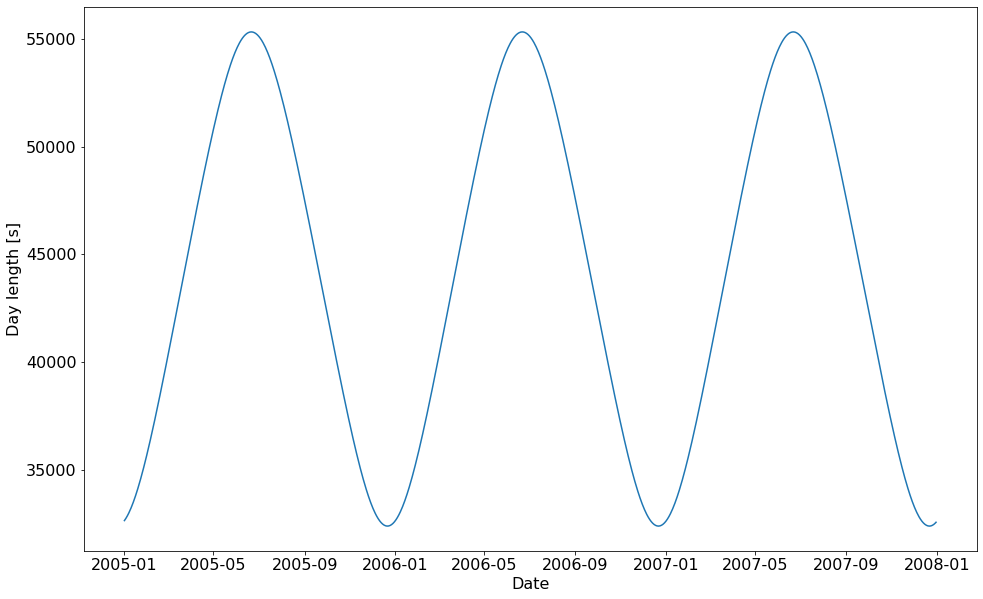

In [9]:
plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 16})
plt.plot(da_tmax_pt.time.values,daylen)
plt.xlabel('Date')
plt.ylabel('Day length [s]')

## 6. Format and write data to file

In [10]:
daylen[0]

32627.93599963188